In [42]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, RepeatVector,TimeDistributed

from sklearn.metrics import confusion_matrix, recall_score, precision_score , accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

# LSTM ver

In [52]:
telemetry = pd.read_csv('./data/PdM_telemetry.csv')
errors = pd.read_csv('./data/PdM_errors.csv')
maint = pd.read_csv('./data/PdM_maint.csv')
failures = pd.read_csv('./data/PdM_failures.csv')
machines = pd.read_csv('./data/PdM_machines.csv')

In [53]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

errors['datetime'] = pd.to_datetime(errors['datetime'],format = '%Y-%m-%d %H:%M:%S')
errors['errorID'] = errors['errorID'].astype('category')

maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')

machines['model'] = machines['model'].astype('category')

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

In [54]:
# create a column for each error type
# error 별 column 생성
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
# 같은 시간으로 통합
error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()
# telemetry 에 통합
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count = error_count.dropna()

In [55]:
# create a column for each error type
# 각 부품별로 생성후 column 명 설정
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
# 기계와 시간별로 교체 부품 정리
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
# telemetry 데이터에 데이터 결합
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None # 0.0인 위치를 모두 None 으로 변경
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    # -comp_rep[comp].isnull() comp_req 의 comp columns 에서 None 이 아닌 부분을 선택(즉 해당 부품의 교체가 발생된 날짜 선택)
    # 해당 부분의 내용을 시간으로 변경
    
    # forward-fill the most-recent date of component change
    # 나머지 빈 부분을 모두 해당 시간으로 교체 (즉 부품 교체일로 변경 날짜)
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)    
# 2014년 이상의 데이터만 선택
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# replace dates of most recent component change with days since most recent component change
# 각 comp 내용을 부품 교체일 부터 얼마나 지났는지로 변경
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')

C:\Users\USER\anaconda3\envs\py38tf2\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [56]:
# 통합 과정
final_feat = telemetry.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

In [57]:
# failure 결합
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
# fillna 가 str일 경우 작동하지 않는 문제 발견 하여 comp 의 마지막 단어를 추출하여 fillna 진행후 comp를 다시 붙이는 방식으로 해결
labeled_features.failure = 'comp' + labeled_features.failure.str[-1].fillna(method='bfill', limit=23) # 앞선 23칸을 failure 로 설정
labeled_features.failure = labeled_features.failure.fillna('none') # 나머지를 none 으로 설정

In [58]:
labeled_features[73:100]

datetime  machineID        volt      rotate    pressure  \
73 2015-01-04 07:00:00          1  142.666469  433.279499  118.853452   
74 2015-01-04 08:00:00          1  191.168936  479.615136  101.999663   
75 2015-01-04 09:00:00          1  157.436263  438.091311  113.100915   
76 2015-01-04 10:00:00          1  153.143558  440.162685   94.524894   
77 2015-01-04 11:00:00          1  215.656488  458.097746   95.036280   
78 2015-01-04 12:00:00          1  173.525320  421.728389  100.617527   
79 2015-01-04 13:00:00          1  169.501121  454.460114   91.675576   
80 2015-01-04 14:00:00          1  129.016707  479.457721  111.575038   
81 2015-01-04 15:00:00          1  168.503141  455.536868   83.689837   
82 2015-01-04 16:00:00          1  184.640476  365.213804   87.474009   
83 2015-01-04 17:00:00          1  176.208034  517.348533   82.400818   
84 2015-01-04 18:00:00          1  183.684832  414.481164  111.684659   
85 2015-01-04 19:00:00          1  199.755983  425.832560  107.335080   
86 2015-01-04 20:00:00          1  187.536628  427.763970  103.159963   
87 2015-01-04 21:00:00          1  162.368945  458.491868   95.748683   
88 2015-01-04 22:00:00          1  180.562703  447.101400   89.260131   
89 2015-01-04 23:00:00          1  167.023756  471.194987   89.474271   
90 2015-01-05 00:00:00          1  161.928938  376.719605   89.969588   
91 2015-01-05 01:00:00          1  127.163620  430.475185   95.667178   
92 2015-01-05 02:00:00          1  158.155297  429.346217   94.892589   
93 2015-01-05 03:00:00          1  177.317220  461.801246  103.056344   
94 2015-01-05 04:00:00          1  202.520488  387.005318   94.686208   
95 2015-01-05 05:00:00          1  177.510419  469.787301  100.498426   
96 2015-01-05 06:00:00          1  179.303153  499.777962  111.833028   
97 2015-01-05 07:00:00          1  155.511452  498.398435  103.068134   
98 2015-01-05 08:00:00          1  172.439821  392.124959  108.135159   
99 2015-01-05 09:00:00          1  138.826437  451.348967  126.464580   

    vibration  error1  error2  error3  error4  error5      comp1       comp2  \
73  54.848731     0.0     0.0     0.0     0.0     0.0  22.041667  217.041667   
74  52.882567     0.0     0.0     0.0     0.0     0.0  22.083333  217.083333   
75  53.695544     0.0     0.0     0.0     0.0     0.0  22.125000  217.125000   
76  57.411078     0.0     0.0     0.0     0.0     0.0  22.166667  217.166667   
77  51.647981     0.0     0.0     0.0     0.0     0.0  22.208333  217.208333   
78  50.458297     0.0     0.0     0.0     0.0     0.0  22.250000  217.250000   
79  45.951349     0.0     0.0     0.0     0.0     0.0  22.291667  217.291667   
80  49.398412     0.0     0.0     0.0     0.0     0.0  22.333333  217.333333   
81  43.917862     0.0     0.0     0.0     0.0     0.0  22.375000  217.375000   
82  52.048152     0.0     0.0     0.0     0.0     0.0  22.416667  217.416667   
83  46.950492     0.0     0.0     0.0     0.0     0.0  22.458333  217.458333   
84  56.837165     0.0     0.0     0.0     0.0     0.0  22.500000  217.500000   
85  41.674887     0.0     0.0     0.0     0.0     0.0  22.541667  217.541667   
86  50.146515     0.0     0.0     0.0     0.0     0.0  22.583333  217.583333   
87  50.240045     0.0     0.0     0.0     0.0     0.0  22.625000  217.625000   
88  51.941914     0.0     0.0     0.0     0.0     0.0  22.666667  217.666667   
89  62.464103     0.0     0.0     0.0     0.0     0.0  22.708333  217.708333   
90  58.087488     0.0     0.0     0.0     0.0     0.0  22.750000  217.750000   
91  46.845600     0.0     0.0     0.0     0.0     0.0  22.791667  217.791667   
92  58.225151     0.0     0.0     0.0     0.0     0.0  22.833333  217.833333   
93  49.894647     0.0     0.0     0.0     0.0     0.0  22.875000  217.875000   
94  45.202347     0.0     0.0     0.0     0.0     0.0  22.916667  217.916667   
95  59.577251     0.0     0.0     0.0     0.0     0.0  22.958333  217.958333   
96  52.383097     0.0     0.0     0.0     0.0    

sclaer

In [59]:
# pick the feature columns 
scaler_cols = ['machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'error1', 'error2', 'error3', 'error4', 'error5', 'comp1', 'comp2',
       'comp3', 'comp4', 'age']

In [60]:
scaler_dict = {}
for col_ in scaler_cols:
    scaler = StandardScaler()
    labeled_features[[col_]] = scaler.fit_transform(labeled_features[[col_]])
    scaler_dict[col_] = scaler

In [61]:
labeled_features[73:100]

datetime  machineID      volt    rotate  pressure  vibration  \
73 2015-01-04 07:00:00  -1.714798 -1.812543 -0.252937  1.628559   2.693139   
74 2015-01-04 08:00:00  -1.714798  1.314742  0.626713  0.103228   2.327035   
75 2015-01-04 09:00:00  -1.714798 -0.860234 -0.161588  1.107932   2.478413   
76 2015-01-04 10:00:00  -1.714798 -1.137014 -0.122265 -0.573267   3.170254   
77 2015-01-04 11:00:00  -1.714798  2.893621  0.218220 -0.526985   2.097152   
78 2015-01-04 12:00:00  -1.714798  0.177137 -0.472227 -0.021861   1.875630   
79 2015-01-04 13:00:00  -1.714798 -0.082330  0.149162 -0.831141   1.036425   
80 2015-01-04 14:00:00  -1.714798 -2.692637  0.623724  0.969835   1.678277   
81 2015-01-04 15:00:00  -1.714798 -0.146677  0.169604 -1.553880   0.657785   
82 2015-01-04 16:00:00  -1.714798  0.893807 -1.545116 -1.211398   2.171665   
83 2015-01-04 17:00:00  -1.714798  0.350110  1.343055 -1.670541   1.222468   
84 2015-01-04 18:00:00  -1.714798  0.832190 -0.609810  0.979756   3.063391   
85 2015-01-04 19:00:00  -1.714798  1.868407 -0.394312  0.586103   0.240138   
86 2015-01-04 20:00:00  -1.714798  1.080542 -0.357645  0.208239   1.817575   
87 2015-01-04 21:00:00  -1.714798 -0.542190  0.225702 -0.462509   1.834991   
88 2015-01-04 22:00:00  -1.714798  0.630885  0.009462 -1.049748   2.151883   
89 2015-01-04 23:00:00  -1.714798 -0.242063  0.466862 -1.030367   4.111140   
90 2015-01-05 00:00:00  -1.714798 -0.570561 -1.326687 -0.985539   3.296204   
91 2015-01-05 01:00:00  -1.714798 -2.812118 -0.306175 -0.469886   1.202937   
92 2015-01-05 02:00:00  -1.714798 -0.813873 -0.327608 -0.539989   3.321837   
93 2015-01-05 03:00:00  -1.714798  0.421627  0.288528  0.198861   1.770677   
94 2015-01-05 04:00:00  -1.714798  2.046654 -1.131420 -0.558667   0.896959   
95 2015-01-05 05:00:00  -1.714798  0.434084  0.440138 -0.032640   3.573601   
96 2015-01-05 06:00:00  -1.714798  0.549674  1.009490  0.993184   2.234032   
97 2015-01-05 07:00:00  -1.714798 -0.984340  0.983300  0.199928  -1.324795   
98 2015-01-05 08:00:00  -1.714798  0.107148 -1.034227  0.658513  -0.169022   
99 2015-01-05 09:00:00  -1.714798 -2.060137  0.090099  2.317394  -0.396195   

      error1  error2    error3    error4    error5     comp1     comp2  \
73 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.503789  2.792392   
74 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.503122  2.793095   
75 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.502455  2.793798   
76 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.501789  2.794501   
77 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.501122  2.795204   
78 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.500455  2.795907   
79 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.499788  2.796610   
80 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.499122  2.797313   
81 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.498455  2.798016   
82 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.497788  2.798719   
83 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.497121  2.799422   
84 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.496455  2.800125   
85 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.495788  2.800828   
86 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.495121  2.801531   
87 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.494454  2.802234   
88 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.493788  2.802937   
89 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.493121  2.803640   
90 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.492454  2.804343   
91 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.491788  2.805046   
92 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.491121  2.805749   
93 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.490454  2.806452   
94 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.489787  2.807155   
95 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0.489121  2.807858   
96 -0.033989 -0.0336 -0.030942 -0.028818 -0.020162 -0

train test split

In [62]:
# make test and training splits
last_train_date, first_test_date = [pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')]

train_y = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date, ['machineID','failure']])
train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['failure'], 1))

test_y = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date, ['machineID','failure']])
test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['failure'], 1))

In [63]:
train_y.columns

Index(['machineID', 'failure_comp1', 'failure_comp2', 'failure_comp3',
       'failure_comp4', 'failure_none'],
      dtype='object')

Train

In [64]:
sequence_length = 50

In [65]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

In [66]:
# pick the feature columns 
sequence_cols = ['machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'error1', 'error2', 'error3', 'error4', 'error5', 'comp1', 'comp2',
       'comp3', 'comp4', 'age', 'model_model1', 'model_model2', 'model_model3',
       'model_model4']

In [67]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_X[train_X['machineID']==id], sequence_length, sequence_cols)) 
           for id in train_X['machineID'].unique())

In [68]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(500923, 50, 19)

In [69]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

In [70]:
# generate labels
label_gen = [gen_labels(train_y[train_y['machineID']==id], sequence_length, ['failure_comp1', 'failure_comp2', 
                                                                            'failure_comp3','failure_comp4', 'failure_none']) 
             for id in train_y['machineID'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(500923, 5)

In [71]:
# build the network
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()

model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=10,
         return_sequences=False))
model.add(Dropout(0.2))

model.add(RepeatVector(50))

model.add(LSTM(
          units=nb_features,
          return_sequences=True))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [72]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 50, 10)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 19)            2280      
Total params: 3,480
Trainable params: 3,480
Non-trainable params: 0
_________________________________________________________________
None


In [73]:
%%time
# fit the network
history= model.fit(seq_array, seq_array, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto')])

Epoch 1/10
2380/2380 [==============================] - 33s 12ms/step - loss: 0.6455 - accuracy: 0.5029 - val_loss: 0.6261 - val_accuracy: 0.4768
Wall time: 32.7 s


In [74]:
# training metrics
scores = model.evaluate(seq_array, seq_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

2505/2505 [==============================] - 16s 6ms/step - loss: 0.5894 - accuracy: 0.6000
Accurracy: 0.5999772548675537


In [93]:
pred_train = model.predict(seq_array)

In [94]:
pred_train.shape

(500923, 50, 19)

In [95]:
scored = np.mean(np.mean(np.abs(pred_train-seq_array),axis=2),axis=1)
plt.figure()
g = sns.distplot(scored, bins = 50, kde= True, color = 'blue');
plt.title('Loss Distribution')
plt.xlabel('Loss (MAE)')
plt.show()

C:\Users\USER\anaconda3\envs\py38tf2\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [96]:
TH = 0.6
scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.mean(np.abs(pred_train-seq_array),axis=2),axis=1)
scored_train['Threshold'] = TH
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

In [97]:
scored_train.plot(logy=True,  figsize = (16,4), xlim =[0,len(scored_train)])
plt.xlabel('Data points')
plt.ylabel('Loss (MAE)')

Text(0, 0.5, 'Loss (MAE)')

In [98]:
scored_train

Loss_mae  Threshold  Anomaly
0       0.539655        0.6    False
1       0.482907        0.6    False
2       0.476620        0.6    False
3       0.472861        0.6    False
4       0.472318        0.6    False
...          ...        ...      ...
500918  0.246210        0.6    False
500919  0.246057        0.6    False
500920  0.248929        0.6    False
500921  0.245846        0.6    False
500922  0.246619        0.6    False

[500923 rows x 3 columns]

In [99]:
anomalies = scored_train[scored_train['Anomaly'] == True]
print(anomalies)
print(anomalies.shape)

        Loss_mae  Threshold  Anomaly
13      0.650430        0.6     True
23      0.677185        0.6     True
40      0.600349        0.6     True
41      0.603302        0.6     True
42      0.605599        0.6     True
...          ...        ...      ...
488707  0.618710        0.6     True
488708  0.617746        0.6     True
488709  0.611684        0.6     True
488710  0.607867        0.6     True
488711  0.602060        0.6     True

[792 rows x 3 columns]
(792, 3)


In [100]:
f, (ax1) = plt.subplots(figsize=(16, 4))
ax1.plot(scored_train.index, scored_train.Loss_mae, label='Loss(MAE)');
ax1.plot(scored_train.index, scored_train.Threshold, label='Threshold')
g = sns.scatterplot(x=anomalies.index , y=anomalies.Loss_mae, label='anomaly', color='red')
g.set(xlim = (0, len(scored_train.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.ylabel('Loss (MAE)')
plt.legend();

In [101]:
pred_train[0][0]

array([-0.18679449,  0.06386698,  0.00145957, -0.09839018, -0.00600045,
       -0.11008492,  0.02918428,  0.13491477, -0.03463808,  0.03599344,
       -0.09144676,  0.24575692,  0.49623287,  0.3185768 ,  0.10349893,
        0.13615347,  0.08720411,  0.04585032,  0.00655313], dtype=float32)

In [102]:
seq_array[0][0]

array([-1.7147976 ,  0.3507433 , -0.53343797,  1.1058528 ,  0.87560904,
       -0.03398905, -0.03359976, -0.03094159, -0.02881776, -0.02016165,
       -0.55246097,  2.7410724 ,  1.7202295 ,  1.9288474 ,  1.1445392 ,
        0.        ,  0.        ,  1.        ,  0.        ], dtype=float32)

In [103]:
true_ = np.sum(label_array[:,:4],axis=1) >= 1.0
scored_train['True'] = true_

In [104]:
scored_train

Loss_mae  Threshold  Anomaly   True
0       0.539655        0.6    False  False
1       0.482907        0.6    False  False
2       0.476620        0.6    False  False
3       0.472861        0.6    False  False
4       0.472318        0.6    False  False
...          ...        ...      ...    ...
500918  0.246210        0.6    False  False
500919  0.246057        0.6    False  False
500920  0.248929        0.6    False  False
500921  0.245846        0.6    False  False
500922  0.246619        0.6    False  False

[500923 rows x 4 columns]

In [105]:
scor_ = accuracy_score(scored_train['True'], scored_train['Anomaly'])
f1_ = f1_score(scored_train['True'], scored_train['Anomaly'])

print(f'acc : {scor_} \n f1 : {f1_}')
confusion_matrix(scored_train['True'], scored_train['Anomaly'])

acc : 0.9793321528458465 
 f1 : 0.03827217835578263


array([[490364,    586],
       [  9767,    206]], dtype=int64)

# ML ver


In [4]:
telemetry = pd.read_csv('./data/PdM_telemetry.csv')
errors = pd.read_csv('./data/PdM_errors.csv')
maint = pd.read_csv('./data/PdM_maint.csv')
failures = pd.read_csv('./data/PdM_failures.csv')
machines = pd.read_csv('./data/PdM_machines.csv')

In [5]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

errors['datetime'] = pd.to_datetime(errors['datetime'],format = '%Y-%m-%d %H:%M:%S')
errors['errorID'] = errors['errorID'].astype('category')

maint['datetime'] = pd.to_datetime(maint['datetime'], format='%Y-%m-%d %H:%M:%S')
maint['comp'] = maint['comp'].astype('category')

machines['model'] = machines['model'].astype('category')

failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')

In [6]:
# Calculate mean values for telemetry features
# pivot_table을 이용 row 시간, columns machin_id 로 구성, 그 후 3시간별 평균으로 설정, 다시 원상복구
# 즉 3시간 기계별 3시간 평균 데이터 생성
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

# repeat for standard deviation
# 추가적인 정보를 넣기 위해 3시간 분산 데이터 추가
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

In [7]:
# 위와 동일한 과정을 24단위 평균을 생성
# 이를 3시간 단위로 짜름(즉 3시간 마다 24시간 평균을 생성)
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                            index='datetime',
                            columns='machineID',
                            values=col).rolling(window=24).mean().resample('3H',
                                                                    closed='left',
                                                                    label='right').first().unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

# repeat for standard deviation
# 전체 데이터를 24단위 분산을 생성 
# 이를 3시간 단위로 짜름(즉 3시간 마다 24시간 분산을 생성)
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                                index='datetime',
                                columns='machineID',
                                values=col).rolling(window=24).std().resample('3H',
                                                                            closed='left',
                                                                            label='right').first().unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]
telemetry_sd_24h.reset_index(inplace=True)

In [8]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.iloc[:, 2:6],
                            telemetry_mean_24h.iloc[:, 2:6],
                            telemetry_sd_24h.iloc[:, 2:6]], axis=1).dropna()

In [9]:
# create a column for each error type
# error 별 column 생성
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']
# 같은 시간으로 통합
error_count = error_count.groupby(['machineID','datetime']).sum().reset_index()
# telemetry 에 통합
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)

In [10]:
# 3시간 마다 24시간 에러 수 표시
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                                index='datetime',
                                columns='machineID',
                                values=col).rolling(window=24).sum().resample('3H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()

In [11]:
# create a column for each error type
# 각 부품별로 생성후 column 명 설정
comp_rep = pd.get_dummies(maint.set_index('datetime')).reset_index()
comp_rep.columns = ['datetime', 'machineID', 'comp1', 'comp2', 'comp3', 'comp4']

# combine repairs for a given machine in a given hour
# 기계와 시간별로 교체 부품 정리
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
# telemetry 데이터에 데이터 결합
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None # 0.0인 위치를 모두 None 으로 변경
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    # -comp_rep[comp].isnull() comp_req 의 comp columns 에서 None 이 아닌 부분을 선택(즉 해당 부품의 교체가 발생된 날짜 선택)
    # 해당 부분의 내용을 시간으로 변경
    
    # forward-fill the most-recent date of component change
    # 나머지 빈 부분을 모두 해당 시간으로 교체 (즉 부품 교체일로 변경 날짜)
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)    
# 2014년 이상의 데이터만 선택
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

# replace dates of most recent component change with days since most recent component change
# 각 comp 내용을 부품 교체일 부터 얼마나 지났는지로 변경
for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]) / np.timedelta64(1, 'D')
    

C:\Users\USER\anaconda3\envs\py38tf2\lib\site-packages\pandas\core\arrays\datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  warnings.warn(


In [12]:
# 통합 과정
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

In [13]:
# failure 결합
labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
# fillna 가 str일 경우 작동하지 않는 문제 발견 하여 comp 의 마지막 단어를 추출하여 fillna 진행후 comp를 다시 붙이는 방식으로 해결
# labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features.failure = 'comp' + labeled_features.failure.str[-1].fillna(method='bfill', limit=7) # 앞선 7칸을 failure 로 설정
labeled_features.failure = labeled_features.failure.fillna('none') # 나머지를 none 으로 설정

In [14]:
labeled_features.head()

machineID            datetime  voltmean_3h  rotatemean_3h  pressuremean_3h  \
0          1 2015-01-02 06:00:00   180.133784     440.608320        94.137969   
1          1 2015-01-02 09:00:00   176.364293     439.349655       101.553209   
2          1 2015-01-02 12:00:00   160.384568     424.385316        99.598722   
3          1 2015-01-02 15:00:00   170.472461     442.933997       102.380586   
4          1 2015-01-02 18:00:00   163.263806     468.937558       102.726648   

   vibrationmean_3h  voltsd_3h  rotatesd_3h  pressuresd_3h  vibrationsd_3h  \
0         41.551544  21.322735    48.770512       2.135684       10.037208   
1         36.105580  18.952210    51.329636      13.789279        6.737739   
2         36.094637  13.047080    13.702496       9.988609        1.639962   
3         40.483002  16.642354    56.290447       3.305739        8.854145   
4         40.921802  17.424688    38.680380       9.105775        3.060781   

   ...  error3count  error4count  error5count   comp1    comp2    comp3  \
0  ...          0.0          0.0          0.0  20.000  215.000  155.000   
1  ...          0.0          0.0          0.0  20.125  215.125  155.125   
2  ...          0.0          0.0          0.0  20.250  215.250  155.250   
3  ...          0.0          0.0          0.0  20.375  215.375  155.375   
4  ...          0.0          0.0          0.0  20.500  215.500  155.500   

     comp4   model  age  failure  
0  170.000  model3   18     none  
1  170.125  model3   18     none  
2  170.250  model3   18     none  
3  170.375  model3   18     none  
4  170.500  model3   18     none  

[5 rows x 30 columns]

In [15]:
labeled_features.failure = pd.Categorical(labeled_features.failure).codes
labeled_features.model = pd.Categorical(labeled_features.model).codes

In [16]:
labeled_features.head()

machineID            datetime  voltmean_3h  rotatemean_3h  pressuremean_3h  \
0          1 2015-01-02 06:00:00   180.133784     440.608320        94.137969   
1          1 2015-01-02 09:00:00   176.364293     439.349655       101.553209   
2          1 2015-01-02 12:00:00   160.384568     424.385316        99.598722   
3          1 2015-01-02 15:00:00   170.472461     442.933997       102.380586   
4          1 2015-01-02 18:00:00   163.263806     468.937558       102.726648   

   vibrationmean_3h  voltsd_3h  rotatesd_3h  pressuresd_3h  vibrationsd_3h  \
0         41.551544  21.322735    48.770512       2.135684       10.037208   
1         36.105580  18.952210    51.329636      13.789279        6.737739   
2         36.094637  13.047080    13.702496       9.988609        1.639962   
3         40.483002  16.642354    56.290447       3.305739        8.854145   
4         40.921802  17.424688    38.680380       9.105775        3.060781   

   ...  error3count  error4count  error5count   comp1    comp2    comp3  \
0  ...          0.0          0.0          0.0  20.000  215.000  155.000   
1  ...          0.0          0.0          0.0  20.125  215.125  155.125   
2  ...          0.0          0.0          0.0  20.250  215.250  155.250   
3  ...          0.0          0.0          0.0  20.375  215.375  155.375   
4  ...          0.0          0.0          0.0  20.500  215.500  155.500   

     comp4  model  age  failure  
0  170.000      2   18        4  
1  170.125      2   18        4  
2  170.250      2   18        4  
3  170.375      2   18        4  
4  170.500      2   18        4  

[5 rows x 30 columns]

In [17]:
labeled_features.columns

Index(['machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'model', 'age', 'failure'],
      dtype='object')

In [18]:
# pick the feature columns 
scaler_cols = ['machineID', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'model', 'age',]

In [19]:
scaler_dict = {}
for col_ in scaler_cols:
    scaler = StandardScaler()
    labeled_features[[col_]] = scaler.fit_transform(labeled_features[[col_]])
    scaler_dict[col_] = scaler

In [20]:
labeled_features.head()

machineID            datetime  voltmean_3h  rotatemean_3h  pressuremean_3h  \
0  -1.714662 2015-01-02 06:00:00     0.984994      -0.180919        -0.906554   
1  -1.714662 2015-01-02 09:00:00     0.588223      -0.218913         0.093518   
2  -1.714662 2015-01-02 12:00:00    -1.093777      -0.670624        -0.170078   
3  -1.714662 2015-01-02 15:00:00    -0.031941      -0.110716         0.205104   
4  -1.714662 2015-01-02 18:00:00    -0.790713       0.674224         0.251776   

   vibrationmean_3h  voltsd_3h  rotatesd_3h  pressuresd_3h  vibrationsd_3h  \
0          0.335752   1.151496     0.185952      -1.449608        2.412228   
1         -1.230778   0.811237     0.296193       1.053134        0.990092   
2         -1.233925  -0.036370    -1.324686       0.236897       -1.207150   
3          0.028386   0.479687     0.509892      -1.198326        1.902305   
4          0.154607   0.591981    -0.248704       0.047298       -0.594750   

   ...  error3count  error4count  error5count     comp1     comp2     comp3  \
0  ...    -0.151341    -0.141682    -0.099272 -0.534260  2.768099  1.741954   
1  ...    -0.151341    -0.141682    -0.099272 -0.532259  2.770212  1.744079   
2  ...    -0.151341    -0.141682    -0.099272 -0.530259  2.772325  1.746205   
3  ...    -0.151341    -0.141682    -0.099272 -0.528258  2.774439  1.748330   
4  ...    -0.151341    -0.141682    -0.099272 -0.526258  2.776552  1.750455   

      comp4     model       age  failure  
0  1.949875  0.164786  1.142152        4  
1  1.951970  0.164786  1.142152        4  
2  1.954066  0.164786  1.142152        4  
3  1.956161  0.164786  1.142152        4  
4  1.958256  0.164786  1.142152        4  

[5 rows x 30 columns]

In [21]:
# make test and training splits
last_train_date, first_test_date = [pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')]

# split out training and test data
train = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                    'machineID'], 1))
                                                                                                    
train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                    'machineID',
                                                                                                    'failure'], 1))

test = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                    'machineID'], 1))
test_y = labeled_features.loc[labeled_features['datetime'] > last_train_date, 'failure']
test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                    'machineID',
                                                                                                    'failure'], 1))
# train and predict using the model, storing results for later

In [22]:
train_X = train_X.values.reshape(-1,1,27)

test_X  = test_X.values.reshape(-1, 1, 27)

In [23]:
# Input layer:
model=Sequential([
    LSTM(32, activation='relu', input_shape=(train_X.shape[1],train_X.shape[2])),
    Dropout(0.2),
    RepeatVector(train_X.shape[1]),
    LSTM(32, activation='relu', return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(train_X.shape[2]))
])

model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                7680      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 32)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 32)             8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 32)             0         
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 27)             891       
Total params: 16,891
Trainable params: 16,891
Non-trainable params: 0
____________________________________________________

In [24]:
# Train model for 100 epochs, batch size of 1000: 
NUM_EPOCHS=50
BATCH_SIZE=1024

history=model.fit(train_X,train_X, 
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.1,
                  shuffle=True)

Epoch 1/50
148/148 [==============================] - 7s 24ms/step - loss: 0.9046 - accuracy: 0.2464 - val_loss: 0.6696 - val_accuracy: 0.4991
Epoch 2/50
148/148 [==============================] - 3s 21ms/step - loss: 0.6576 - accuracy: 0.4488 - val_loss: 0.4955 - val_accuracy: 0.5991
Epoch 3/50
148/148 [==============================] - 3s 21ms/step - loss: 0.5901 - accuracy: 0.4999 - val_loss: 0.4408 - val_accuracy: 0.6368
Epoch 4/50
148/148 [==============================] - 3s 20ms/step - loss: 0.5595 - accuracy: 0.5206 - val_loss: 0.4079 - val_accuracy: 0.6734
Epoch 5/50
148/148 [==============================] - 3s 21ms/step - loss: 0.5408 - accuracy: 0.5271 - val_loss: 0.3865 - val_accuracy: 0.6962
Epoch 6/50
148/148 [==============================] - 3s 20ms/step - loss: 0.5293 - accuracy: 0.5303 - val_loss: 0.3730 - val_accuracy: 0.7027
Epoch 7/50
148/148 [==============================] - 3s 21ms/step - loss: 0.5209 - accuracy: 0.5309 - val_loss: 0.3613 - val_accuracy: 0.7135

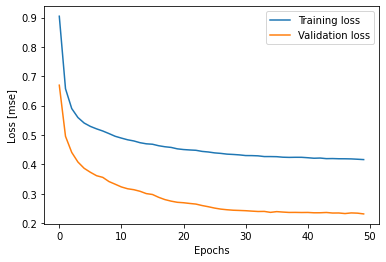

In [25]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss [mse]')
plt.show()

In [68]:
model.save('saved_model/LSTM_automodel.hdf5')

In [26]:
pred_train = model.predict(train_X)

In [27]:
pred_train = pred_train.reshape(pred_train.shape[0],pred_train.shape[2])
train_X = train_X.reshape(train_X.shape[0],train_X.shape[2])

C:\Users\USER\anaconda3\envs\py38tf2\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


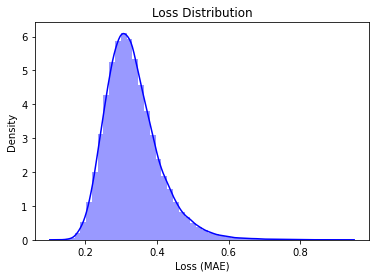

In [29]:
scored = np.mean(np.abs(pred_train-train_X), axis = 1)
plt.figure()
g = sns.distplot(scored, bins = 50, kde= True, color = 'blue');
plt.title('Loss Distribution')
plt.xlabel('Loss (MAE)')
plt.show()

In [30]:
TH = 0.6
pred_train = pd.DataFrame(pred_train)
scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.abs(pred_train-train_X), axis = 1)
scored_train['Threshold'] = TH
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']

evaluate train

Text(0, 0.5, 'Loss (MAE)')

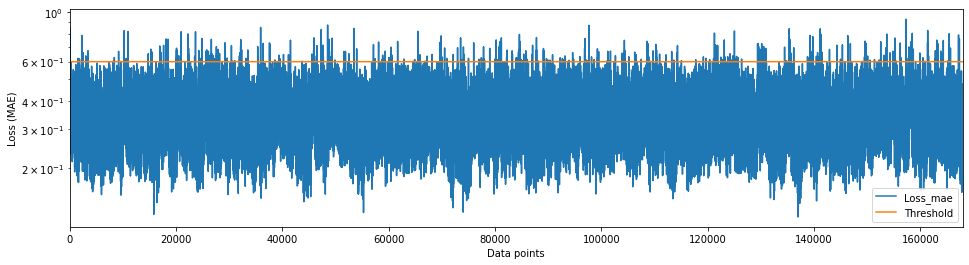

In [31]:
scored_train.plot(logy=True,  figsize = (16,4), xlim =[0,len(scored_train)])
plt.xlabel('Data points')
plt.ylabel('Loss (MAE)')

In [32]:
anomalies = scored_train[scored_train['Anomaly'] == True]
print(anomalies)
print(anomalies.shape)

        Loss_mae  Threshold  Anomaly
14      0.679776        0.6     True
15      0.703120        0.6     True
16      0.729542        0.6     True
17      0.856343        0.6     True
18      0.711200        0.6     True
...          ...        ...      ...
167327  0.759723        0.6     True
167328  0.714162        0.6     True
167329  0.705331        0.6     True
167330  0.627057        0.6     True
167332  0.624616        0.6     True

[980 rows x 3 columns]
(980, 3)


In [33]:
f, (ax1) = plt.subplots(figsize=(16, 4))
ax1.plot(scored_train.index, scored_train.Loss_mae, label='Loss(MAE)');
ax1.plot(scored_train.index, scored_train.Threshold, label='Threshold')
g = sns.scatterplot(x=anomalies.index , y=anomalies.Loss_mae, label='anomaly', color='red')
g.set(xlim = (0, len(scored_train.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.ylabel('Loss (MAE)')
plt.legend();

0         4
1         4
2         4
3         4
4         4
         ..
290102    4
290103    4
290104    4
290105    4
290106    4
Name: failure, Length: 167922, dtype: int8

In [62]:
true_ = train_y < 4.0
true_ = true_.reset_index(drop=True)
scored_train['True'] = true_

In [63]:
scor_ = accuracy_score(scored_train['True'], scored_train['Anomaly'])
f1_ = f1_score(scored_train['True'], scored_train['Anomaly'])

print(f'acc : {scor_} \n f1 : {f1_}')
confusion_matrix(scored_train['True'], scored_train['Anomaly'])

acc : 0.9796869975345697 
 f1 : 0.2109646079111728


array([[164055,    524],
       [  2887,    456]], dtype=int64)

evaluate test

In [34]:
pred_test = model.predict(test_X)

In [35]:
score = model.evaluate(test_X,test_X)
score

3810/3810 [==============================] - 15s 4ms/step - loss: 0.2081 - accuracy: 0.8143


[0.20813876390457153, 0.8143126368522644]

In [36]:
pred_test = pred_test.reshape(pred_test.shape[0],pred_test.shape[2])
test_X = test_X.reshape(test_X.shape[0],test_X.shape[2])

C:\Users\USER\anaconda3\envs\py38tf2\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


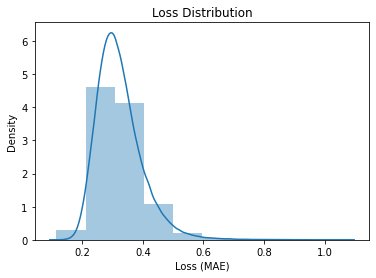

In [37]:
scored_test = np.mean(np.abs(pred_test-test_X), axis = 1)
plt.figure()
g = sns.distplot(scored_test, bins = 10, kde= True);
plt.title('Loss Distribution')
plt.xlabel('Loss (MAE)')
plt.show()

In [38]:
scored_test = pd.DataFrame()
scored_test['Loss_mae'] = np.mean(np.abs(pred_test-test_X), axis = 1)
scored_test['Threshold'] = TH
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold']

scored_test

Loss_mae  Threshold  Anomaly
0       0.211510        0.6    False
1       0.258494        0.6    False
2       0.301704        0.6    False
3       0.284165        0.6    False
4       0.210882        0.6    False
...          ...        ...      ...
121915  0.363713        0.6    False
121916  0.344129        0.6    False
121917  0.231606        0.6    False
121918  0.300610        0.6    False
121919  0.261500        0.6    False

[121920 rows x 3 columns]

Text(0, 0.5, 'Loss (MAE)')

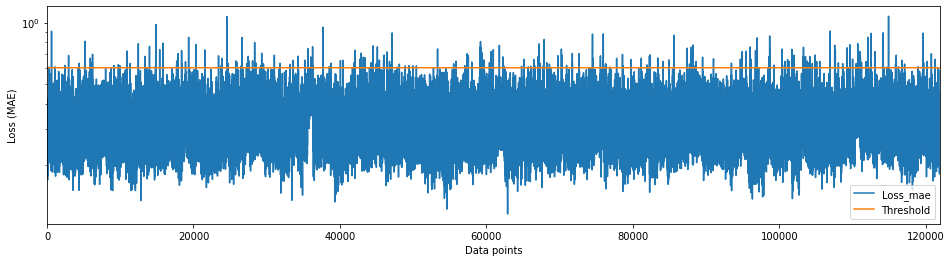

In [39]:
scored_test.plot(logy=True,  figsize = (16,4), xlim =[0,len(scored_test)])
plt.xlabel('Data points')
plt.ylabel('Loss (MAE)')

In [40]:
IR_anomalies = scored_test[scored_test['Anomaly'] == True]
print(IR_anomalies)
print(IR_anomalies.shape)

        Loss_mae  Threshold  Anomaly
259     0.605190        0.6     True
609     0.658672        0.6     True
610     0.719429        0.6     True
611     0.831857        0.6     True
612     0.721002        0.6     True
...          ...        ...      ...
120765  0.698189        0.6     True
121241  0.638358        0.6     True
121242  0.602485        0.6     True
121243  0.660859        0.6     True
121247  0.614086        0.6     True

[705 rows x 3 columns]
(705, 3)


In [41]:
f, (ax2) = plt.subplots(figsize=(18, 6))
ax2.plot(scored_test.index, scored_test.Loss_mae, label='Loss(MAE)');
ax2.plot(scored_test.index, scored_test.Threshold, label='Threshold')
g = sns.scatterplot(x=IR_anomalies.index , y=IR_anomalies.Loss_mae, label='anomaly', color='red')
g.set(xlim = (0, len(scored_test.index)))
plt.title('Anomalies')
plt.xlabel('Data points')
plt.ylabel('Loss (MAE)')
plt.legend();

In [64]:
true_ = test_y < 4.0
true_ = true_.reset_index(drop=True)
scored_test['True'] = true_

In [67]:
scor_ = accuracy_score(scored_test['True'], scored_test['Anomaly'])
f1_ = f1_score(scored_test['True'], scored_test['Anomaly'])

print(f'acc : {scor_} \n f1 : {f1_}')
confusion_matrix(scored_test['True'], scored_test['Anomaly'])

acc : 0.9755905511811024 
 f1 : 0.0060120240480961915


array([[118935,    696],
       [  2280,      9]], dtype=int64)